In [2]:
from autogluon.tabular import TabularDataset, TabularPredictor
import pandas as pd
import numpy as np

train_path = r'D:\xjtufiles\3ee\DGA\datasets\DGA_data_add_cleaned_train.csv'
test_path = r'D:\xjtufiles\3ee\DGA\datasets\DGA_data_add_cleaned_test.csv'

# 预处理训练集
df_train = pd.read_csv(train_path)

df_train['h2'] = pd.to_numeric(df_train['h2'], errors='coerce')
df_train['ch4'] = pd.to_numeric(df_train['ch4'], errors='coerce')
df_train['c2h6'] = pd.to_numeric(df_train['c2h6'], errors='coerce')
df_train['c2h4'] = pd.to_numeric(df_train['c2h4'], errors='coerce')
df_train['c2h2'] = pd.to_numeric(df_train['c2h2'], errors='coerce')
df_train['act'] = pd.to_numeric(df_train['act'], errors='coerce')

df_train = df_train.reset_index(drop=True)  # 重置索引

# 预处理测试集
df_test = pd.read_csv(test_path)

df_test['h2'] = pd.to_numeric(df_test['h2'], errors='coerce')
df_test['ch4'] = pd.to_numeric(df_test['ch4'], errors='coerce')
df_test['c2h6'] = pd.to_numeric(df_test['c2h6'], errors='coerce')
df_test['c2h4'] = pd.to_numeric(df_test['c2h4'], errors='coerce')
df_test['c2h2'] = pd.to_numeric(df_test['c2h2'], errors='coerce')
df_test['act'] = pd.to_numeric(df_test['act'], errors='coerce')

df_test = df_test.reset_index(drop=True)  # 重置索引

feature_cols = ['h2', 'ch4', 'c2h6', 'c2h4', 'c2h2']

for col in feature_cols:
    df_train[col] = pd.to_numeric(df_train[col], errors='coerce')
    df_test[col] = pd.to_numeric(df_test[col], errors='coerce')

df_train['act'] = df_train['act'].astype(int)
df_test['act'] = df_test['act'].astype(int)

c:\Users\11094\.conda\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train_Duval = df_train.copy()
test_Duval = df_test.copy()

def Duval_triangle_features(X):
    """
    根据Duval 三角法扩展特征矩阵。

    Args:
        X (pd.DataFrame): 包含 h2, ch4, c2h6, c2h4, c2h2 列的特征矩阵。

    Returns:
        pd.DataFrame: 扩展后的特征矩阵。
    """

    # 计算比值
    R1 = X['c2h2'] / (X['c2h2'] + X['ch4'] + X['c2h6']+ 1e-6 )
    R2 = X['ch4'] /  (X['c2h2'] + X['ch4'] + X['c2h6'] + 1e-6)
    R3 = X['c2h6'] /  (X['c2h2'] + X['ch4'] + X['c2h6']+ 1e-6 )

    # 处理异常值
    R1 = R1.replace([np.inf, -np.inf], 0).fillna(0)
    R2 = R2.replace([np.inf, -np.inf], 0).fillna(0)
    R3 = R3.replace([np.inf, -np.inf], 0).fillna(0)

    # 添加到特征矩阵
    X['R1: %C2H2'] = R1
    X['R2: %CH4'] = R2
    X['R3: %C2H6'] = R3

    return X

Duval_train_data = Duval_triangle_features(train_Duval)
Duval_test_data = Duval_triangle_features(test_Duval)


## Gini随机森林 + SMOTE

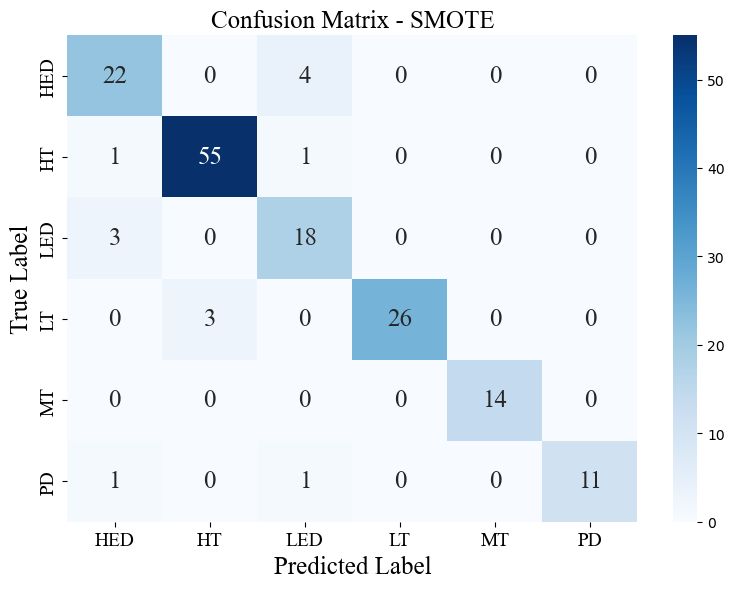


=== 模型总体评估指标 ===

[No Oversampling]
Accuracy: 0.8938
Precision: 0.8852
Recall: 0.8802
F1: 0.8812

[SMOTE]
Accuracy: 0.9125
Precision: 0.9188
Recall: 0.9018
F1: 0.9081

=== 每类指标报告 ===

[No Oversampling]
     precision  recall  f1-score
HED     0.7857  0.8462    0.8148
HT      0.9483  0.9649    0.9565
LED     0.7273  0.7619    0.7442
LT      1.0000  0.8621    0.9259
MT      0.9333  1.0000    0.9655
PD      0.9167  0.8462    0.8800

[SMOTE]
     precision  recall  f1-score
HED     0.8148  0.8462    0.8302
HT      0.9483  0.9649    0.9565
LED     0.7500  0.8571    0.8000
LT      1.0000  0.8966    0.9455
MT      1.0000  1.0000    1.0000
PD      1.0000  0.8462    0.9167


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, classification_report, confusion_matrix)
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, KMeansSMOTE

# 标签映射
category_mapping = {
    1: 'HED',
    2: 'HT',
    3: 'LED',
    4: 'LT',
    5: 'MT',
    6: 'PD'
}
target_names = [category_mapping[i] for i in sorted(category_mapping.keys())]

# 提取特征和标签
X_train = Duval_train_data.drop('act', axis=1)
y_train = Duval_train_data['act']
X_test = Duval_test_data.drop('act', axis=1)
y_test = Duval_test_data['act']

# 模型训练与评估函数
def train_and_evaluate(X_train, y_train, X_test, y_test, return_pred=False):
    model = RandomForestClassifier(n_estimators=100, criterion='gini', random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # 总体指标
    overall_metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='macro', zero_division=0),
        'Recall': recall_score(y_test, y_pred, average='macro', zero_division=0),
        'F1': f1_score(y_test, y_pred, average='macro', zero_division=0)
    }

    # 每类指标报告
    report_df = pd.DataFrame(classification_report(y_test, y_pred, target_names=target_names, output_dict=True, zero_division=0)).transpose()

    if return_pred:
        return overall_metrics, report_df, y_pred, model
    else:
        return overall_metrics, report_df

# 重采样方法
resamplers = {
    'No Oversampling': None,
    'SMOTE': SMOTE(random_state=42),
    # 'ADASYN': ADASYN(random_state=42),
    # 'BorderlineSMOTE': BorderlineSMOTE(random_state=42),
    # 'KMeansSMOTE': KMeansSMOTE(random_state=42)
}

# 存储评估结果
results = OrderedDict()

for method, sampler in resamplers.items():
    if sampler is None:
        X_res, y_res = X_train, y_train
    else:
        X_res, y_res = sampler.fit_resample(X_train, y_train)

    if method == "SMOTE":
        overall, report_df, y_pred, model = train_and_evaluate(X_res, y_res, X_test, y_test, return_pred=True)
        # 混淆矩阵可视化
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_test, y_pred, labels=sorted(model.classes_))
        class_names = [category_mapping[i] for i in sorted(model.classes_)]
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names,
                    annot_kws={"size": 18, "fontname": "Times New Roman"})
        plt.xlabel('Predicted Label', fontsize=18, fontname='Times New Roman')
        plt.ylabel('True Label', fontsize=18, fontname='Times New Roman')
        plt.title(f'Confusion Matrix - {method}', fontsize=18, fontname='Times New Roman')
        plt.xticks(fontsize=14, fontname='Times New Roman')
        plt.yticks(fontsize=14, fontname='Times New Roman')
        plt.tight_layout()
        plt.show()
    else:
        overall, report_df = train_and_evaluate(X_res, y_res, X_test, y_test)

    results[method] = (overall, report_df)

# 输出所有结果
print("\n=== 模型总体评估指标 ===")
for method, (metrics, _) in results.items():
    print(f"\n[{method}]")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

print("\n=== 每类指标报告 ===")
for method, (_, report_df) in results.items():
    print(f"\n[{method}]")
    print(report_df.loc[target_names][['precision', 'recall', 'f1-score']].round(4))


## Gini随机森林 + SMOTE + SHAP

In [5]:
import shap

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

model = RandomForestClassifier(n_estimators=100, criterion='gini', random_state=42)
model.fit(X_resampled, y_resampled)
y_pred = model.predict(X_test)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)


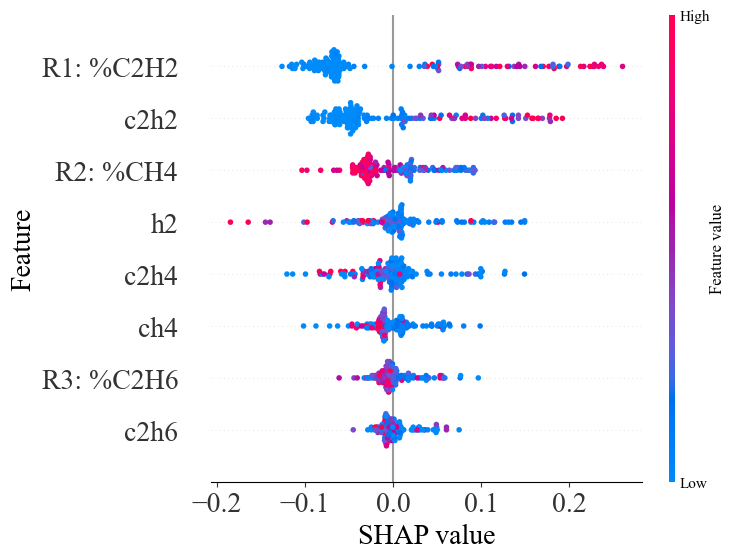

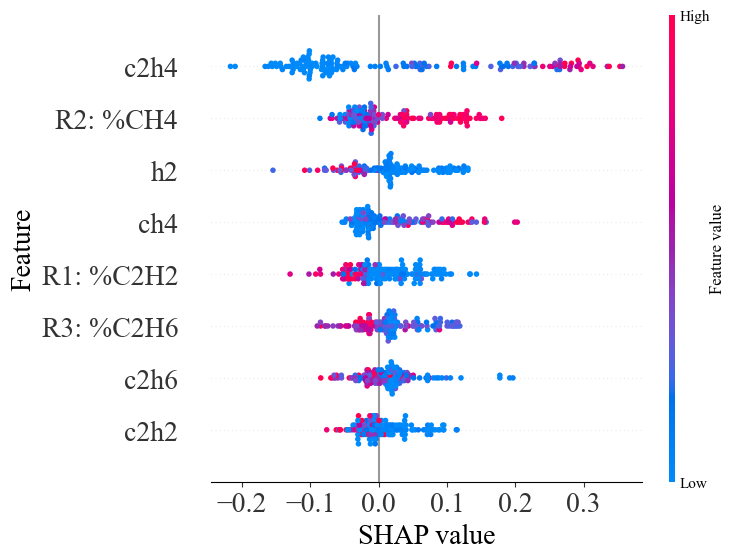

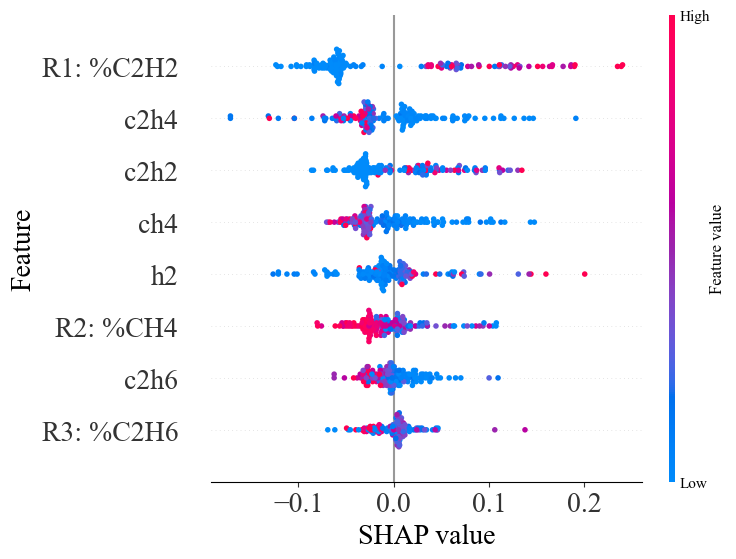

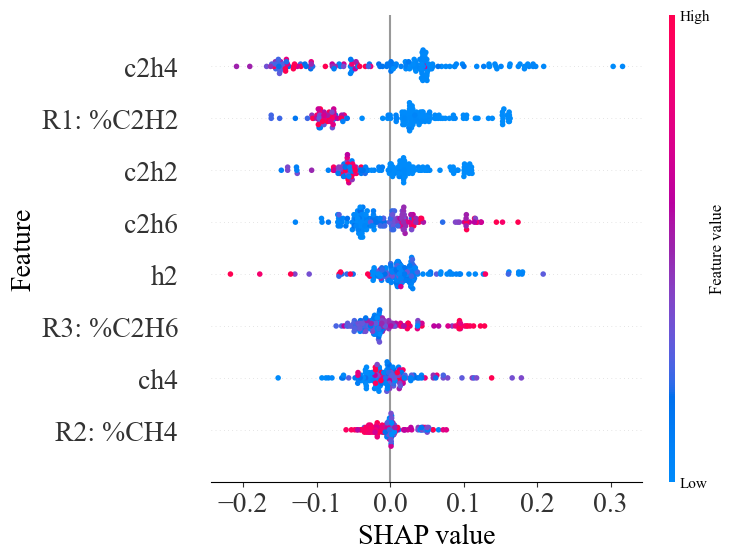

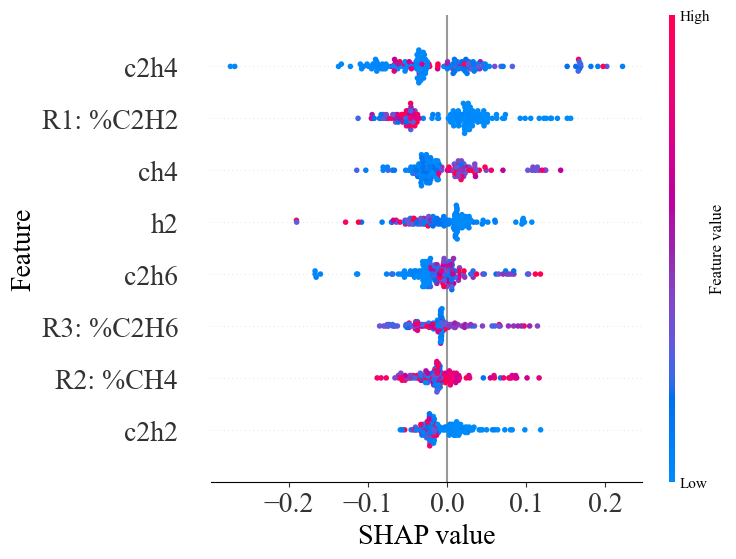

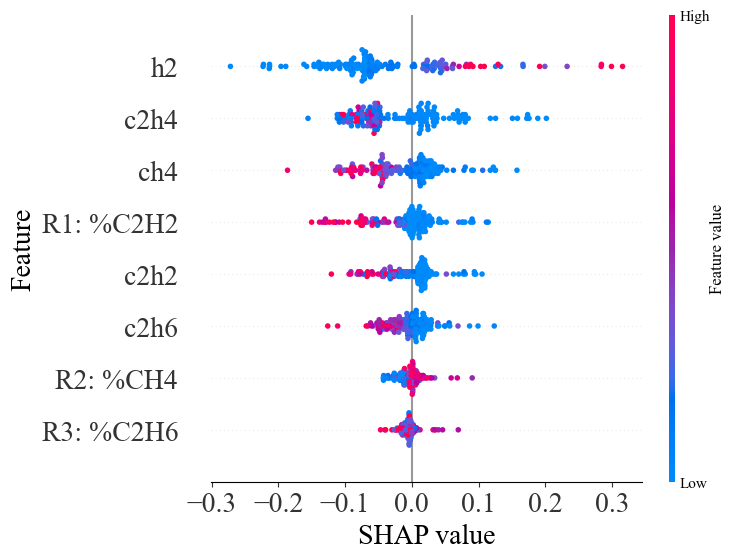

In [14]:
import matplotlib.pyplot as plt
import shap
import matplotlib

# 设置全局字体
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 20
matplotlib.rc('font', family='Times New Roman')
matplotlib.rcParams['font.size'] = 20

# 假设 final_model, X_test, shap_values 已定义
for i, class_name in enumerate(model.classes_):
    shap.summary_plot(
        shap_values[:, :, i],
        X_test,
        class_names=[class_name],
        title=f"SHAP Summary Plot for Class {class_name}",
        show=False  # 关键：不立即显示图，让我们可以改它
    )

    fig = plt.gcf()  # 获取当前 figure
    fig.set_size_inches(8, 6)  # 设置图像大小

    # 修改字体大小（xticks/yticks/label/title）
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel("SHAP value", fontsize=20)
    plt.ylabel("Feature", fontsize=20)
    #plt.title(f"SHAP Summary Plot for Class {class_name}", fontsize=22)

    plt.tight_layout()
    plt.show()



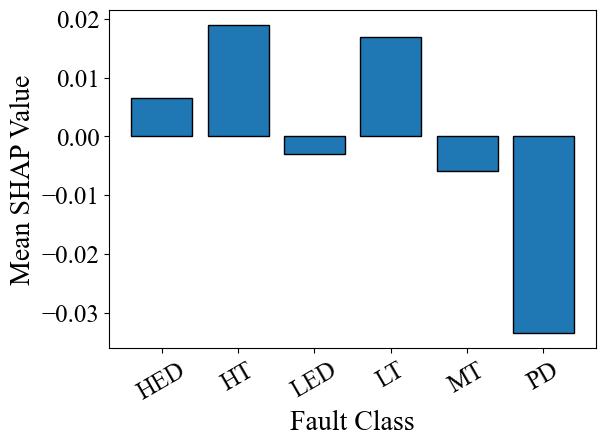

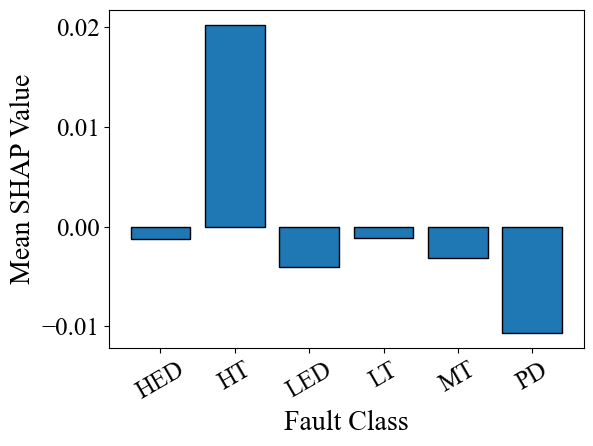

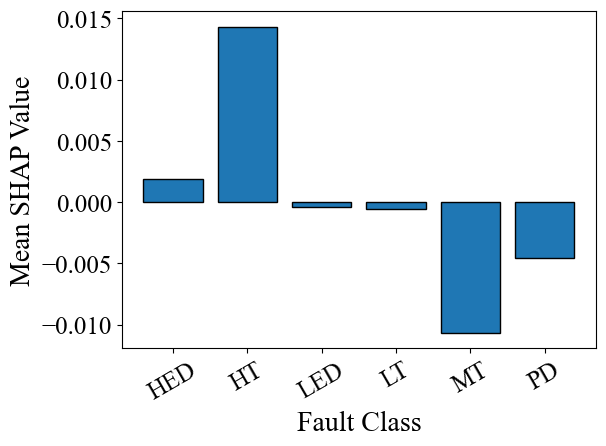

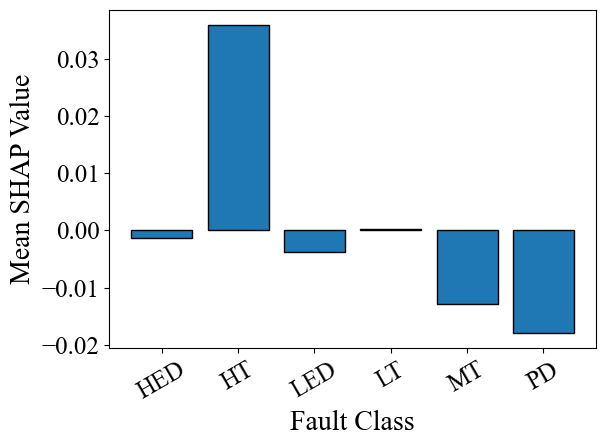

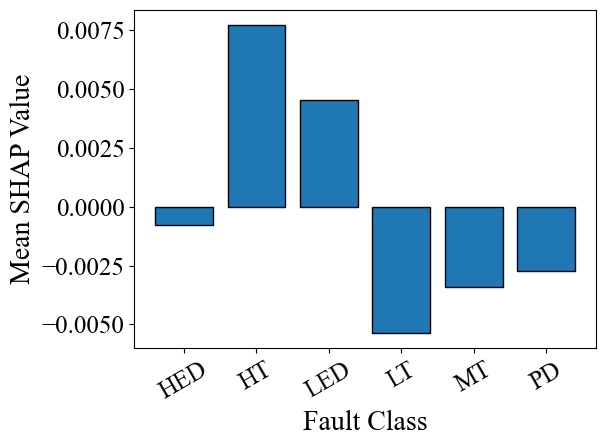

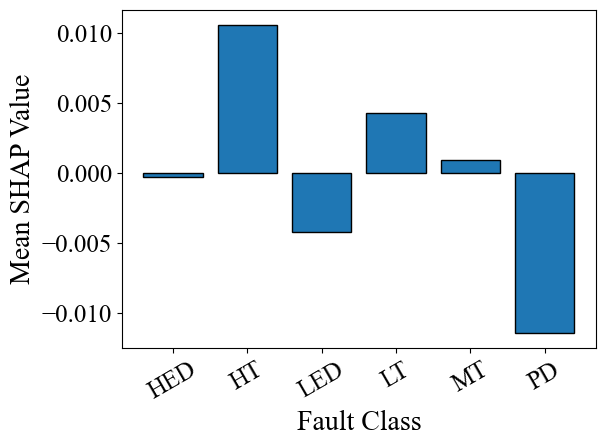

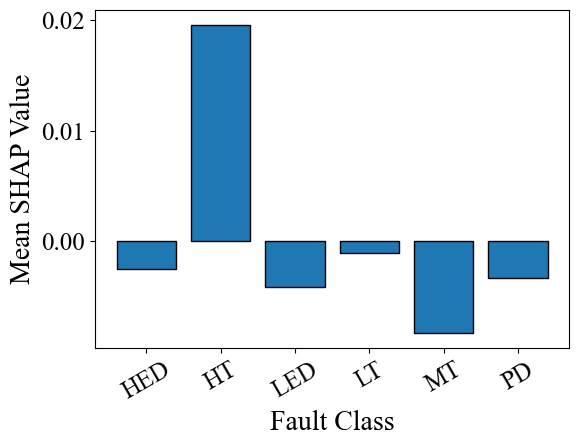

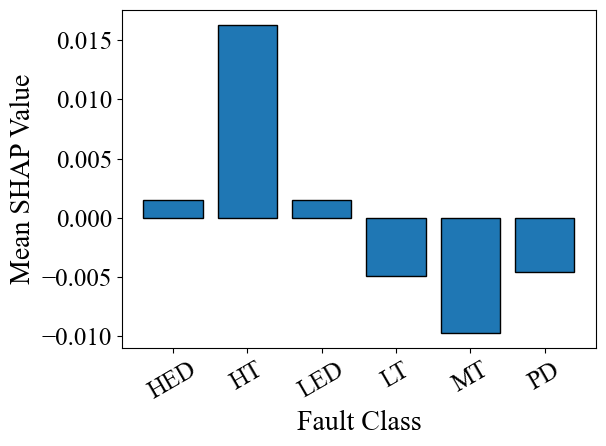

In [25]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib

# 类别映射字典
category_mapping = {
    1: 'HED',
    2: 'HT',
    3: 'LED',
    4: 'LT',
    5: 'MT',
    6: 'PD'
}

# 设置全局字体
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 18
matplotlib.rc('font', family='Times New Roman')
matplotlib.rcParams['font.size'] = 18

for feature_name in X_test.columns:
    feature_index = X_test.columns.get_loc(feature_name)
    mean_shap_values = shap_values[:, feature_index, :].mean(axis=0)

    class_labels = [category_mapping[cls] for cls in model.classes_]

    plt.figure()
    plt.bar(
        class_labels, mean_shap_values,
        edgecolor='black',      # 添加边框
        linewidth=1           # 边框线宽（可选）
    )
    plt.xlabel("Fault Class", fontsize=20)
    plt.ylabel("Mean SHAP Value", fontsize=20)
    # plt.title(f"Mean SHAP Value for {feature_name}", fontsize=18)
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()


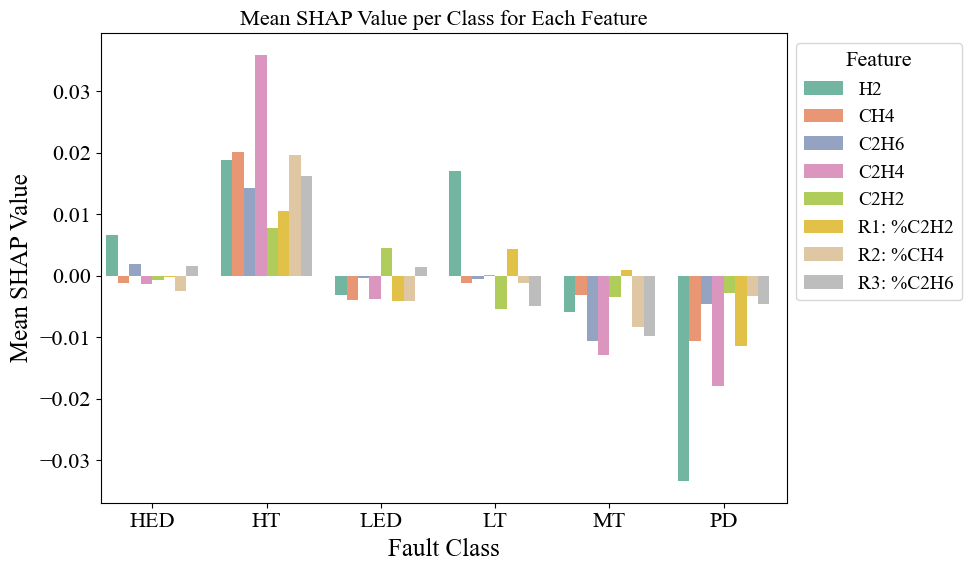

In [21]:
import matplotlib.pyplot as plt
import numpy as np

model_colors = [
    '#72b6a1', '#e99675', '#95a3c3', '#db96c0',
    '#b0cc5a', '#e2c148', '#dfc7a3', '#bdbdbd'
]

# 特征名改为大写
feature_names = [f.upper() for f in X_test.columns.tolist()]
num_features = len(feature_names)
num_classes = len(model.classes_)

# 创建平均 SHAP 值矩阵：shape = [num_features, num_classes]
mean_shap_matrix = np.zeros((num_features, num_classes))
for i, feature_name in enumerate(X_test.columns):
    feature_index = X_test.columns.get_loc(feature_name)
    mean_shap_matrix[i] = shap_values[:, feature_index, :].mean(axis=0)

# 绘图
x = np.arange(num_classes)
bar_width = 0.1

plt.figure(figsize=(10, 6))
for i in range(num_features):
    plt.bar(x + i * bar_width, mean_shap_matrix[i],
            width=bar_width,
            color=model_colors[i % len(model_colors)],
            label=feature_names[i])

# 设置 x-ticks 居中
plt.xticks(x + bar_width * (num_features - 1) / 2, class_labels)

# 设置边距刚好包住所有柱子（核心改进）
total_width = bar_width * num_features
plt.xlim(x[0] - 0.1, x[-1] + total_width + 0.1)

# 其他设置
plt.xlabel("Fault Class", fontsize=18)
plt.ylabel("Mean SHAP Value", fontsize=18)
plt.title("Mean SHAP Value per Class for Each Feature", fontsize=16)
plt.legend(title="Feature", bbox_to_anchor=(1, 1), loc='upper left', fontsize=14)
plt.tight_layout()
plt.show()
